# Baseline model - census income prediction

Task: predict whether a person earns more or less than $50k.

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, r2_score
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
import pickle


sns.set(style='white', context='notebook', palette='deep')

## 2. Load Data

In [2]:
train_df = pd.read_csv("data/census_income/adult_data", sep=', ')
test_df = pd.read_csv("data/census_income/adult.test", sep=', ')

dataset = pd.concat([train_df, test_df])

C:\Users\benja\AppData\Local\Temp\ipykernel_19552\319179932.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  train_df = pd.read_csv("data/census_income/adult_data", sep=', ')
C:\Users\benja\AppData\Local\Temp\ipykernel_19552\319179932.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  test_df = pd.read_csv("data/census_income/adult.test", sep=', ')


## Modeling

In [26]:
dataset = dataset.sample(frac=1, random_state=42).reset_index(drop=True)
X_train, Y_train = (
    dataset.iloc[:32561].drop("income", axis=1),
    dataset.iloc[:32561]["income"],
)
X_test, Y_test = (
    dataset.iloc[32561:].drop("income", axis=1),
    dataset.iloc[32561:]["income"],
)

In [27]:
X_test = pd.read_csv('data/preprocessed/X_test.csv', index=False)
X_train = pd.read_csv('data/preprocessed/X_train.csv', index=False)
Y_test = pd.read_csv('data/preprocessed/Y_test.csv', index=False)
Y_train = pd.read_csv('data/preprocessed/Y_train.csv', index=False)

In [28]:
models = [
    ("LR", LogisticRegression()),
    ("KNN", KNeighborsClassifier()),
    ("CART", DecisionTreeClassifier()),
    ("NB", GaussianNB()),
    ("RF", RandomForestClassifier()),
    ("XGB", XGBClassifier()),
]

param_grids = {

    "LogisticRegression": {
        "C": [0.01, 0.1, 1, 10, 100],
        "penalty": ["l1", "l2"],
        "solver": ["liblinear", "saga"],
    },

    "KNeighborsClassifier": {
        "n_neighbors": [3, 5, 7, 9],
        "weights": ["uniform", "distance"],
        "metric": ["euclidean", "manhattan"],
    },

    "DecisionTreeClassifier": {
        "max_depth": [3, 5, 10, None],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
    },

    "GaussianNB": {"var_smoothing": [1e-9, 1e-8, 1e-7]},

    "RandomForestClassifier": {
        "n_estimators": [100, 200, 300],
        "max_features": [2, 3, 4],
        "max_depth": [None, 3, 5, 10],
    },

    "XGBClassifier": {
        "n_estimators": [100, 200, 300],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5, 7],
    },

}

In [31]:
#cell runs in 2min15
skf = StratifiedKFold(n_splits=5)
searches = {}
SCORING_METRIC = "roc_auc"
for name, model in models:
    print(f"Running RandomizedSearchCV for {model.__class__.__name__}")
    search = RandomizedSearchCV(
        model,
        param_grids[model.__class__.__name__],
        cv=skf.split(X_train, Y_train),
        scoring=SCORING_METRIC,
        n_jobs=-1,
        )
    search.fit(X_train, Y_train)
    searches[name] = search
    with open(f"models/{name}.pkl", "wb") as f:
        pickle.dump(search.best_estimator_, f)

Running RandomizedSearchCV for LogisticRegression
Running RandomizedSearchCV for KNeighborsClassifier


c:\ProgramData\Anaconda3\envs\tabtext_py3.10\lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.83891171        nan 0.87521732 0.84298527
        nan        nan        nan 0.87135311]
  warnings.warn(


Running RandomizedSearchCV for DecisionTreeClassifier
Running RandomizedSearchCV for GaussianNB


c:\ProgramData\Anaconda3\envs\tabtext_py3.10\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Running RandomizedSearchCV for RandomForestClassifier


c:\ProgramData\Anaconda3\envs\tabtext_py3.10\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "c:\ProgramData\Anaconda3\envs\tabtext_py3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\ProgramData\Anaconda3\envs\tabtext_py3.10\lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\ProgramData\Anaconda3\envs\tabtext_py3.10\lib\site-packages\sklearn\base.py", line 637, in _validate_params
    vali

Running RandomizedSearchCV for XGBClassifier


c:\ProgramData\Anaconda3\envs\tabtext_py3.10\lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\Anaconda3\envs\tabtext_py3.10\lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\Anaconda3\envs\tabtext_py3.10\lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\Anaconda3\envs\tabtext_py3.10\lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
 

In [32]:
def find_best_threshold(y_true, y_prob):
    best_threshold = 0.5
    best_score = 0
    for threshold in np.arange(0.1, 0.9, 0.001):
        score = f1_score(y_true, y_prob >= threshold)
        if score > best_score:
            best_score = score
            best_threshold = threshold
    return best_threshold


In [33]:
# cell runs in 1min50
names = []
accuracies = []
aucs = []
precisions = []
recalls = []
best_thresholds = []
scores =[]
r2s = []
for name, search in searches.items():
    model = search.best_estimator_
    probas = model.predict_proba(X_train.values)[:, 1]
    best_threshold = find_best_threshold(Y_train, probas) # for f1

    # metrics on test set
    preds = (model.predict_proba(X_test.values)[:, 1] >= best_threshold).astype(int)

    auc = roc_auc_score(Y_test, preds)
    accuracy = accuracy_score(Y_test, preds)
    precision = precision_score(Y_test, preds)
    recall = recall_score(Y_test, preds)
    r2 = r2_score(Y_test, preds)

    names.append(name)
    aucs.append(auc)
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    r2s.append(r2)
    scores.append(search.best_score_)
    best_thresholds.append(best_threshold)

    msg = f"{name}: Best Threshold {best_threshold:.2f} - Accuracy {accuracy:.4f} - AUC {auc:.4f}"
    print(msg)

c:\ProgramData\Anaconda3\envs\tabtext_py3.10\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\ProgramData\Anaconda3\envs\tabtext_py3.10\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\ProgramData\Anaconda3\envs\tabtext_py3.10\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


LR: Best Threshold 0.35 - Accuracy 0.8373 - AUC 0.8008


c:\ProgramData\Anaconda3\envs\tabtext_py3.10\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


KNN: Best Threshold 0.45 - Accuracy 0.8431 - AUC 0.7889


c:\ProgramData\Anaconda3\envs\tabtext_py3.10\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\ProgramData\Anaconda3\envs\tabtext_py3.10\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\ProgramData\Anaconda3\envs\tabtext_py3.10\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


CART: Best Threshold 0.33 - Accuracy 0.8433 - AUC 0.7953


c:\ProgramData\Anaconda3\envs\tabtext_py3.10\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
c:\ProgramData\Anaconda3\envs\tabtext_py3.10\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


NB: Best Threshold 0.28 - Accuracy 0.8150 - AUC 0.7961


c:\ProgramData\Anaconda3\envs\tabtext_py3.10\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


RF: Best Threshold 0.29 - Accuracy 0.8174 - AUC 0.7997
XGB: Best Threshold 0.36 - Accuracy 0.8606 - AUC 0.8243


In [34]:
metrics = pd.DataFrame(
    {
        #"Best threshold": best_thresholds,
        "Accuracy": accuracies,
        "AUC": aucs,
        "Precision": precisions,
        "Recall": recalls,
        "R2": r2s,
        "Training score": scores,
    },
    index=names,
).transpose()
metrics["Best Value"] = metrics.max(axis=1)
metrics["Best Model"] = metrics.idxmax(axis=1)
metrics

,LR,KNN,CART,NB,RF,XGB,Best Value,Best Model
Accuracy,0.837295,0.843130,0.843314,0.814999,0.817395,0.860635,0.860635,XGB
AUC,0.800765,0.788875,0.795258,0.796093,0.799655,0.824272,0.824272,XGB
Precision,0.632436,0.659045,0.654192,0.580768,0.584582,0.683637,0.683637,XGB
Recall,0.731937,0.686649,0.704712,0.760471,0.766230,0.755759,0.766230,RF
R2,0.093961,0.126454,0.127480,-0.030196,-0.016857,0.223933,0.223933,XGB
Training score,0.905705,0.875217,0.900072,0.891805,0.899970,0.929102,0.929102,XGB


In [38]:
params = {}
for name, search in searches.items():
    params[name] = search.best_params_
with open(f"models/params.pkl", "wb") as f:
        pickle.dump(params, f)

## Appendix

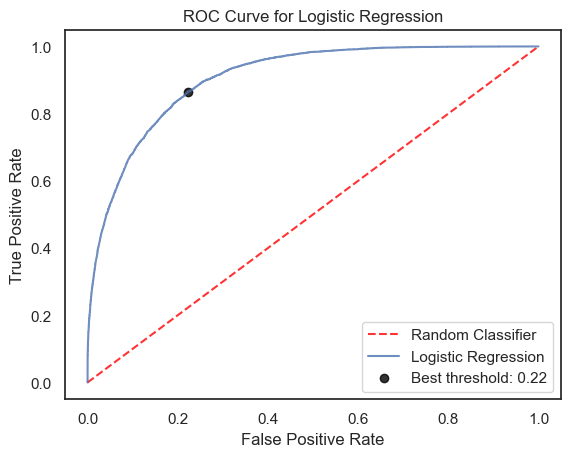

In [161]:

plt.plot([0, 1], [0, 1], linestyle="--", color="red", alpha=0.8, label="Random Classifier")
plt.plot(fpr, tpr, alpha=0.8, label="Logistic Regression")
fpr, tpr, thresholds = metrics.roc_curve(Y_train, preds)
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
plt.scatter(
    fpr[ix], tpr[ix], marker="o", color="black", alpha=0.8, label=f"Best threshold: {best_thresh:.2f}"
)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Logistic Regression")
plt.legend()

In [163]:
LR_best = estimators["LR"].best_estimator_
preds = LR_best.predict_proba(X_train.values)[:, 1]
best_threshold = find_best_threshold(Y_train, preds)

c:\ProgramData\Anaconda3\envs\tabtext_py3.10\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [22]:
from sklearn.model_selection import StratifiedKFold, KFold

kf = KFold(n_splits=5, shuffle=False)
print("No stratification:")
for train, test in kf.split(X_train, Y_train):
    print(f"Train {np.bincount(Y_train[train])} - Test {np.bincount(Y_train[test])}")

print("\nWith stratification:")
skf = StratifiedKFold(n_splits=5).split(X_train, Y_train)
for train, test in skf.split(X_train, Y_train):
    print(f"Train {np.bincount(Y_train[train])} - Test {np.bincount(Y_train[test])}")

No stratification:
Train [19909  6139] - Test [4933 1580]
Train [19922  6127] - Test [4920 1592]
Train [19863  6186] - Test [4979 1533]
Train [19871  6178] - Test [4971 1541]
Train [19803  6246] - Test [5039 1473]

With stratification:
Train [19873  6175] - Test [4969 1544]
Train [19874  6175] - Test [4968 1544]
Train [19874  6175] - Test [4968 1544]
Train [19874  6175] - Test [4968 1544]
Train [19873  6176] - Test [4969 1543]
